# Learning Non-linear Features in Neural Networks
---

I had recently watched a [interview](https://youtu.be/UMpSrvGB4zs) of Geoffrey Hinton by Andrew Ng. In that interview the question of activation functions came up, and it was mentioned  how it took many layers of sigmoid activations to get a ReLU activation. This brought up something I did not have an intuitive handle on. How did a neural network learn arbitrary non-linear functions? How many layers and how much data would it take to learn such a function?

Since I learn by doing, I decided to use this opportunity to play around with tensorflow to answer these questions.

## The data

The non-linear functions I'm aiming to learn are multiplication and squaring. I feel like these are fairly simple commonly used when feature engineering, so it might be useful to know how much it would take to replicate those.

So I'm going to start off with 10000 training examples. I'm not sure if I want the dependent variables to be exact or have some noise, so I will create both

In [1]:
import numpy as np

np.random.seed(5)

n = 10000
noise_std = 10
X = np.random.random([2, n]).astype(np.float32)*1000
y_mul = np.reshape(X[0]*X[1], [1, X.shape[1]])
y_mul_noisy = y_mul + np.random.standard_normal(n)*noise_std
y_sq = np.reshape(X[0]*X[0]**2, [1, X.shape[1]])
y_sq_noisy = y_sq + np.random.standard_normal(n)*noise_std

X, y_mul, y_mul_noisy, y_sq = X.T, y_mul.T, y_mul_noisy.T, y_sq.T 

print(X.shape, y_mul.shape, y_mul_noisy.shape, y_sq.shape)

(10000, 2) (10000, 1) (10000, 1) (10000, 1)


Now a neural network architecture needs to be chosen. Though it should not work, I am going with the simplest configuration, a perceptron, or single layer network. A perceptron for regression will basically look for a linear combination of the inputs to get the output. You can't really model either of the functions with a linear combination, but the errors from this will serve as a benchmark to compare other architectures to.

In [2]:
import tensorflow as tf

learning_rate = 0.0001
training_epochs = 1000
display_step = 50
batch_size = 200
num_outputs = 1

graph = tf.Graph()
with graph.as_default():
    tf_X = tf.placeholder(tf.float32, shape=(batch_size, X.shape[1]))
    tf_Y = tf.placeholder(tf.float32, shape=(batch_size, num_outputs))

    weights = tf.Variable(tf.random_normal([X.shape[1], num_outputs]))
    bias = tf.Variable(tf.random_normal([num_outputs]))
    bias = tf.Print(bias, [bias], message="Bias is: ")
    y_hat = y_hat = tf.matmul(tf_X, weights) + bias
    tf.Print(y_hat, [y_hat], message="Output is:")
    cost = tf.reduce_sum(tf.pow(y_hat-tf_Y, 2))/(2*n)
    cost = tf.Print(cost, [cost], message="Cost is: ")
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    train_prediction = tf.matmul(tf_X, weights) + bias

In [3]:
# X.T[0].reshape([1,2])
y_mul.shape

(10000, 1)

In [5]:
from collections import OrderedDict

def error(predictions, labels):
  return (np.sum((predictions - labels)**2)/(2*n))

errors = OrderedDict()

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        offset = (epoch * batch_size) % (X.shape[0] - batch_size) # Somewhat randomization of the offset
        batch_data = X[offset:(offset + batch_size), :]
        batch_labels = y_mul_noisy[offset:(offset + batch_size), :]
        feed_dict = {tf_X: batch_data, tf_Y: batch_labels}
        _, l, predictions = sess.run([optimizer, cost, train_prediction], feed_dict=feed_dict)
        if (epoch % display_step == 0):
            print("Minibatch cost at step %d: %f" % (epoch, l))
            print("Minibatch MSE: %f" % error(predictions, batch_labels))
            errors[epoch] = error(predictions, batch_labels)

Minibatch cost at step 0: 1300377216.000000
Minibatch MSE: 1300377123.244512
Minibatch cost at step 50: 156812768.000000
Minibatch MSE: 156812766.959641
Minibatch cost at step 100: 168331392.000000
Minibatch MSE: 168331399.554393
Minibatch cost at step 150: 147304448.000000
Minibatch MSE: 147304444.225241
Minibatch cost at step 200: 171925584.000000
Minibatch MSE: 171925581.524996
Minibatch cost at step 250: 148141328.000000
Minibatch MSE: 148141315.831436
Minibatch cost at step 300: 165693008.000000
Minibatch MSE: 165693001.006926
Minibatch cost at step 350: 154232576.000000
Minibatch MSE: 154232575.519483
Minibatch cost at step 400: 144568976.000000
Minibatch MSE: 144568973.521105
Minibatch cost at step 450: 171114992.000000
Minibatch MSE: 171115009.875684
Minibatch cost at step 500: 147084528.000000
Minibatch MSE: 147084515.412983
Minibatch cost at step 550: 154816480.000000
Minibatch MSE: 154816473.303626
Minibatch cost at step 600: 140529920.000000
Minibatch MSE: 140529920.930011


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

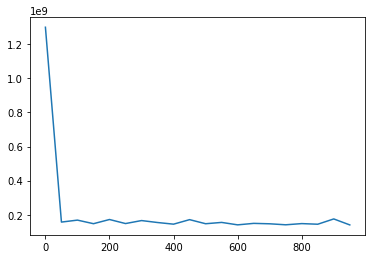

In [7]:
plt.plot(errors.keys(), errors.values())